<a id='top'></a>
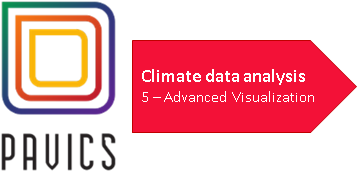

This tutorial outlines steps for visualizing and summarizing an ensemble of climate simulations into more understandable and usable representations. While tutorials up to this point have shown numerous examples of creating plots and figures from our climate data, this notebook will focus on the use of more sophisticated tools for the creation of interactive plots and tables directly in the jupyter environment through the use of the <a href="https://holoviz.org/" target="_blank">holoviz</a> ecosystem. These types of summary workflows and representations, often used on climate change information portals such as Ouranos' <a href="https://www.ouranos.ca/climate-portraits/#/" target="_blank">climate portraits</a> or the canada-wide scale <a href="https://climatedata.ca/" target="_blank">climatedata.ca</a> include:

* [Maps of climate normals](#maps)
* [Time-series plots](#timeseries)
* [Table summaries](#tables)

Advanced topics:
* [Interactive dashboarding](#advanced)

<div class="alert alert-info"> <strong>Info!</strong> This notebook accesses files created in tutorial 3. Be sure to run the <strong>advanced</strong> section of the <strong>climate indicator calculation</strong> tutorial before beginning.
</div>
<div class="alert alert-info">
To conserve any modifications to tutorial notebooks in the PAVICS JupyterLab they need to be copied into your <a href=#workspace>writable-workspace</a> directory.    
</div>

## Ensemble dataset preparation
We will re-use the concepts of the ensembles tutorial in a slightly more complex way to prepare a dataset containing climate indicator output for both of our variables as well as including both RCP 4.5 and RCP 8.5 simulations.  "Unstacking" the time dimension of our data via the custom sub-function `unstack_yr_season` will allow us to calculate 30 year averages for all seasons simultaneously with `xarray` operations such as <a href="https://xarray.pydata.org/en/stable/generated/xarray.Dataset.rolling.html" target="_blank">rolling</a> or <a href="https://xarray.pydata.org/en/v0.12.0/generated/xarray.Dataset.coarsen.html" target="_blank">coarsen</a> as well as examine individual seasons in our interactive plots and maps

*[return to top of page](#top)*

In [1]:
# NBVAL_IGNORE_OUTPUT

import logging
import warnings
from pathlib import Path

import holoviews as hv
import hvplot
import hvplot.pandas
import hvplot.xarray
import numpy as np
import pandas as pd
import panel as pn
import xarray as xr
from bokeh.models.tools import HoverTool
from clisops.core import subset
from holoviews import streams
from IPython.display import clear_output
from xclim import ensembles as xens
from xclim.core import units

logging.getLogger().disabled = True
warnings.simplefilter("ignore")
pn.extension()

clear_output()

# Sub function definitions


def unstack_yr_season(ds):
    """Translate resampled data to a multi-index year [int] / season [string]"""

    ind = pd.MultiIndex.from_arrays(
        [
            ds.time.dt.year.values + (ds.time.dt.month.values == 12).astype(int),
            ds.time.dt.month.values,
        ],
        names=["year", "season"],
    )
    dsout = ds.assign(time=ind).unstack("time")
    if len(pd.unique(dsout.season.values)) == 12:
        seas_label = [calendar.month_name[m] for m in range(1, 13)]
    else:
        all_labels = {
            1: "Annual",
            3: "Spring",
            6: "Summer",
            7: "Annual (jul-jun)",
            9: "Fall",
            12: "Winter",
        }
        seas_label = [all_labels[m] for m in pd.unique(dsout.season.values)]
    return dsout.assign_coords(season=seas_label)


output = "/notebook_dir/writable-workspace/tmp/tutorial3/output"
infolder = Path(output)
ds_all = []
for rcp in ["rcp45", "rcp85"]:
    ds_vars = []
    for v in ["tx_mean", "tx_days_above_27_degC"]:
        for f in ["YS", "QS-DEC"]:
            # create a list of datasets for which the time dimension has been "unstacked"
            ncfiles = [
                unstack_yr_season(xr.open_dataset(d, decode_timedelta=False))
                for d in infolder.glob(f"{v}*{f}*{rcp}*.nc")
            ]

            # Create an ensemble dataset from the 11 simulations for the given rcp
            # Add a new rcp dimension and corodinate
            ds_vars.append(
                xens.create_ensemble(ncfiles).assign_coords(rcp=rcp).expand_dims("rcp")
            )

    # Create a single dataset with both variables
    ds_all.append(xr.merge(ds_vars))

# concatenate the 2 rcp datasets together along the new 'rcp' dim
ds_ens = xr.concat(ds_all, dim="rcp")
ds_ens = ds_ens.sel(year=slice(1971, 2100))  # select years 1971-2100

# It is usually more intuitive to visualize temperature in Celsius
for v in ds_ens.data_vars:
    if units.units2pint(ds_ens[v]) == "kelvin":
        ds_ens[v] = units.convert_units_to(ds_ens[v], "degC")
ds_ens

<xarray.Dataset>
Dimensions:        (year: 130, season: 5, lat: 18, lon: 44, realization: 11,
                    rcp: 2)
Coordinates:
  * year           (year) int64 1971 1972 1973 1974 1975 ... 2097 2098 2099 2100
  * season         (season) <U6 'Annual' 'Fall' 'Spring' 'Summer' 'Winter'
  * lat            (lat) float32 49.29 49.21 49.12 49.04 ... 48.04 47.96 47.87
  * lon            (lon) float32 -67.71 -67.63 -67.55 ... -64.3 -64.21 -64.13
  * realization    (realization) int64 0 1 2 3 4 5 6 7 8 9 10
  * rcp            (rcp) <U5 'rcp45' 'rcp85'
Data variables:
    tx_mean        (rcp, realization, lat, lon, year, season) float32 nan ......
    tx_days_above  (rcp, realization, lat, lon, year, season) float64 nan ......
Attributes: (12/27)
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    2011-06-01T01:08:07Z CMOR rewrote data to com...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Os...
    driving_model:              NorESM1-M
    ...                         ...
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Norwegian Climate Centre
    driving_institute_id:       NCC
    crs:                        EPSG:4326

<a id='maps'></a>
___
## Maps of climate normals
In this section we examine steps to create an interactive map of 30 year climatologies. First we calculate 30 year averages on our ensemble dataset
as well as a subsequent delta change calculation with respect to a reference period. We then calculate ensembles percentiles of the 30 year normals. Finally we employ <a href="https://holoviz.org/" target="_blank">holoviz</a> tools to create an interactive figure to explore the data. *Remember the importance of calculating ensemble percentiles as a last step (see [notes](#notes)).*

*[return to top of page](#top)*

In [2]:
# NBVAL_IGNORE_OUTPUT

# 30 year means and delta calculations
window = 30
d30yAvg = ds_ens.rolling(year=window).mean()
d30yAvg = d30yAvg.isel(
    year=slice(window - 1, None)
)  # Select from the first full windowed mean

# Select every horizons in 10 y intervals
d30yAvg = d30yAvg.sel(year=(d30yAvg.year.values % 10 == 0))
horizons = xr.DataArray(
    [f"{yr - 29}-{yr}" for yr in d30yAvg.year.values], dims=dict(year=d30yAvg.year)
)
d30yAvg = d30yAvg.assign_coords(horizon=horizons)


# Calculate deltas
ref = d30yAvg.sel(year=(d30yAvg.horizon == "1981-2010")).squeeze()
for v in d30yAvg.data_vars:
    with xr.set_options(keep_attrs=True):
        d30yAvg[f"{v}_delta"] = d30yAvg[v] - ref[v]
        for a in ["description", "long_name"]:
            d30yAvg[f"{v}_delta"].attrs[
                a
            ] = f"{d30yAvg[f'{v}_delta'].attrs[a]} : delta vs 1981-2010"


# Calculate percentiles on 30y normals
d30yAvg_ens = xens.ensemble_percentiles(d30yAvg, split=False).load()
display(d30yAvg_ens)
map1 = (
    d30yAvg_ens.swap_dims({"year": "horizon"})
    .drop_vars("year")
    .tx_mean.hvplot.quadmesh(
        x="lon",
        y="lat",
        cmap="Spectral_r",
        geo=True,
        tiles="EsriImagery",
        framewise=False,
        frame_width=400,
    )
)
map1

<xarray.Dataset>
Dimensions:              (year: 11, season: 5, lat: 18, lon: 44, rcp: 2,
                          percentiles: 3)
Coordinates:
  * year                 (year) int64 2000 2010 2020 2030 ... 2080 2090 2100
  * season               (season) <U6 'Annual' 'Fall' 'Spring' 'Summer' 'Winter'
  * lat                  (lat) float32 49.29 49.21 49.12 ... 48.04 47.96 47.87
  * lon                  (lon) float32 -67.71 -67.63 -67.55 ... -64.21 -64.13
  * rcp                  (rcp) <U5 'rcp45' 'rcp85'
    horizon              (year) <U9 '1971-2000' '1981-2010' ... '2071-2100'
  * percentiles          (percentiles) int64 10 50 90
Data variables:
    tx_mean              (rcp, lat, lon, year, season, percentiles) float64 n...
    tx_days_above        (rcp, lat, lon, year, season, percentiles) float64 n...
    tx_mean_delta        (rcp, lat, lon, year, season, percentiles) float64 n...
    tx_days_above_delta  (rcp, lat, lon, year, season, percentiles) float64 n...
Attributes: (12/32)
    units:                      °C
    cell_methods:                time: mean over days
    history:                    2011-06-01T01:08:07Z CMOR rewrote data to com...
    standard_name:              air_temperature
    long_name:                  Mean daily maximum temperature
    description:                Annual mean of daily maximum temperature.
    ...                         ...
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Norwegian Climate Centre
    driving_institute_id:       NCC
    crs:                        EPSG:4326

:DynamicMap   [percentiles,horizon,rcp,season]
   :Overlay
      .Tiles.I    :Tiles   [x,y]
      .QuadMesh.I :QuadMesh   [lon,lat]   (tx_mean)

___
<a id='timeseries'></a>
### Regional averaging and time-series graphs
Here we employ tools to create time series graphs for a number of sub-regions of interest. We first calculate the proportion of individual gridcells intersecting each sub-region in order to calculate a weighted average of conditions for each sub-region.  *Remember the importance of calculating ensemble percentiles as a last step (see [notes](#notes))*
  


*[return to top of page](#top)*

In [3]:
import geopandas as gpd
import hvplot.pandas

gdf = gpd.GeoDataFrame.from_file(
    "/notebook_dir/pavics-homepage/tutorial_data/gaspesie_mrc.geojson"
)
gdf = gdf.dissolve(by="MUS_NM_MRC")
gdf["region_name"] = gdf.index

# TODO replace with clisops average.average_shape() once it can do a 'skipna'
# mask of valid (non-nan) data cells
data_mask = (
    ds_ens.tx_mean.isel(rcp=0, realization=0).mean(dim=["year", "season"]).notnull()
)
# spatial weights of gridcells interesecting each polygon
weight_masks = subset.create_weight_masks(ds_ens, poly=gdf)


def clean_masks(data_mask, masks):
    # remove weight values of gridcells that are nan in the actual data. Rescale so total == 1
    return (masks * data_mask) / (masks * data_mask).sum(dim=["lat", "lon"])


weight_masks = clean_masks(data_mask, weight_masks)

# Calculate weighted average for each region
with xr.set_options(keep_attrs=True):
    reg_ts_sims = (ds_ens * weight_masks).sum(dim=["lat", "lon"])
    reg_ts = xens.ensemble_percentiles(reg_ts_sims)
reg_ts.load()

# get only tx_mean percentile variables for this plot
vars1 = [v for v in reg_ts if "tx_mean" in v]
clear_output()
# plot a simple map of the sub-regions
display(
    gdf.hvplot(
        geo=True,
        color="region_name",
        tiles="EsriImagery",
        legend=False,
        frame_width=400,
    )
)

# Interative time-series plot of regional means
reg_ts[vars1].hvplot.line(
    x="year", title="time series of regional mean conditions"
).opts(legend_position="top_left", frame_width=500)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]   (region_name)

:DynamicMap   [geom,rcp,season]
   :NdOverlay   [Variable]
      :Curve   [year]   (value)

<a id='tables'></a>
## Summary tables
Here we produce a summary table of regional 30 year means for all variables and horizons.  *Remember the importance of calculating ensemble percentiles as a last step (see [notes](#notes))*


*[return to top of page](#top)*

In [4]:
# NBVAL_IGNORE_OUTPUT

# Start with 30 year means from mapping step
# Calculate weighted average for each region as in last step
with xr.set_options(keep_attrs=True):
    reg30y_sims = (d30yAvg * weight_masks).sum(dim=["lat", "lon"])
    reg30y_ens = xens.ensemble_percentiles(reg30y_sims)
    # make the 'horizon' field the index of our table. rename the 'geom' field to 'region'
    df = (
        reg30y_ens.swap_dims(dict(year="horizon"))
        .rename({"geom": "region"})
        .to_dataframe()
    )
df.hvplot.table(
    title="Summary table", fit_columns=False, sortable=True, selectable=True, width=2000
)

:Table   [rcp,horizon,season,region,tx_mean_p10,tx_mean_p50,tx_mean_p90,year,region_name,tx_days_above_p10,tx_days_above_p50,tx_days_above_p90,tx_mean_delta_p10,tx_mean_delta_p50,tx_mean_delta_p90,tx_days_above_delta_p10,tx_days_above_delta_p50,tx_days_above_delta_p90]

<a id='advanced'></a>
___
## Advanced interactive plots and dashboarding
While simple interactive plots can rapidly be achieved using the xarray or pandas <a href="https://hvplot.holoviz.org/user_guide/Gridded_Data.html" target="_blank">hvplot</a> extensions more powerful custom controls can be accomplished by leveraging <a href="https://panel.holoviz.org/" target="_blank">panel</a> for the creation of custom widgets and controls allowing for interactive maps and figures with standardized color limits and options such as variable selection, display of delta change values, and opacity.

*[return to top of page](#top)*

### Dashboarding - advanced controls & mapping

In [5]:
## widgets setup

# variable menu
vars = pn.widgets.Select(
    options=[v for v in list(d30yAvg_ens.data_vars.keys()) if "_delta" not in v],
    width=125,
)
vars1 = pn.Column(pn.pane.Markdown("**Select variable**"), vars)

# delta checkbox
delta = pn.widgets.Checkbox(value=False)
delta1 = pn.Column(pn.pane.Markdown("**display deltas**"), delta)

# seasons menu
seasons = pn.widgets.Select(
    options=list(d30yAvg_ens.season.values), value="Summer", width=125
)
seasons1 = pn.Column(pn.pane.Markdown("**season**"), seasons)

# percentiles menu
perc = pn.widgets.RadioButtonGroup(
    options=list(d30yAvg_ens.percentiles.values), value=50, width=125
)
perc1 = pn.Column(pn.pane.Markdown("**ensemble percentile**"), perc)

# horizons menu
hors = pn.widgets.DiscreteSlider(
    options=list(d30yAvg_ens.horizon.values), value="2041-2070", width=200
)
hors1 = pn.Column(pn.pane.Markdown("**horizon**"), hors)

# rcps menu
rcps = pn.widgets.RadioButtonGroup(
    options=list(d30yAvg_ens.rcp.values), value="rcp85", width=125
)
rcps1 = pn.Column(pn.pane.Markdown("**emissions scenario**"), rcps)

# regions menu
regions = pn.widgets.Select(options=list(reg_ts.geom.values))
regions1 = pn.Column(pn.pane.Markdown("**region**"), regions)

# transparency control
trs = pn.widgets.FloatInput(value=0.8, start=0.0, end=1.0, step=0.2, width=60)
trs1 = pn.Column(pn.pane.Markdown("opacity"), trs)


## Dynamically change map using the pn.depends decorator
@pn.depends(
    vars.param.value,
    seasons.param.value,
    perc.param.value,
    hors.param.value,
    rcps.param.value,
    trs.param.value,
    delta.param.value,
)
def plot_map(
    v=vars.param.value,
    s=seasons.param.value,
    p=perc.param.value,
    h=hors.param.value,
    r=rcps.param.value,
    alpha=trs.param.value,
    delta_flag=delta.param.value,
):
    out = d30yAvg_ens.swap_dims(dict(year="horizon"))
    if delta_flag:
        v = f"{v}_delta"
        tool_lab = f"delta vs {ref.horizon.values} ({out[v].attrs['units']})"
    else:
        tool_lab = f"{out[v].attrs['long_name']}  ({out[v].attrs['units']})"
    clim = (out[v].sel(season=s).min().values, out[v].sel(season=s).max().values)
    out = out.sel(season=s, percentiles=p, horizon=h, rcp=r)
    hover = HoverTool(tooltips=[(tool_lab, f"@{v}")])
    title = pn.pane.Markdown(
        f"### {s} {out[v].attrs['long_name'].lower()} \
            ({out[v].attrs['units'].lower()})<br/> {h} : {r} ({p}th percentile)".replace(
            "  ", " "
        )
    )
    return pn.Column(
        title,
        pn.Row(
            out[v].hvplot.quadmesh(
                alpha=alpha,
                xlabel="lon",
                ylabel="lat",
                cmap="Spectral_r",
                clim=clim,
                geo=True,
                tiles="CartoLight",
                tools=[hover],
                frame_width=650,
            ),
            trs1,
        ),
    )


map1 = pn.Column(plot_map, pn.Row(vars1, seasons1, rcps1, perc1, hors1, delta1))
# map1  # Uncomment to visualization map-only

### Dashboarding - time-series and summary table
* add regional time-series plot 
* add table summary of all seasons for selected region & horizon
* combine the three elements into simple dashboard

In [6]:
# NBVAL_IGNORE_OUTPUT

rolling = pn.widgets.FloatInput(value=30, step=10, start=10, end=30, width=50)
rolling1 = pn.Column(pn.pane.Markdown("Smoothing"), rolling)

## Time-series plot


@pn.depends(
    vars.param.value, regions.param.value, seasons.param.value, rolling.param.value
)
def plot_region_ts(
    v=vars.param.value,
    reg=regions.param.value,
    s=seasons.param.value,
    wind=rolling.param.value,
):
    colors = dict(rcp45="#0000FF", rcp85="#FF0000")
    plt1 = None
    wind = max(wind, 1)
    for r in reg_ts.rcp.values:
        if plt1 is None:
            plt1 = (
                reg_ts.rolling(year=wind, center=True, min_periods=1)
                .mean(dim="year")
                .sel(geom=reg, season=s, rcp=r)
                .hvplot.area(
                    title=f"{reg} {s}",
                    width=800,
                    height=300,
                    x="year",
                    y=f"{v}_p10",
                    y2=f"{v}_p90",
                    color=colors[r],
                    alpha=0.3,
                    line_alpha=0.1,
                    label=f"RCP {r[-2:].replace('5','.5')}",
                )
            )
            plt1 = plt1 * reg_ts.rolling(year=wind, center=True, min_periods=1).mean(
                dim="year"
            ).sel(geom=reg, season=s, rcp=r).hvplot.line(
                x="year",
                y=f"{v}_p50",
                color=colors[r],
                alpha=0.7,
                label=f"RCP {r[-2:].replace('5','.5')}",
            )

        else:
            plt1 = plt1 * reg_ts.rolling(year=wind, center=True, min_periods=1).mean(
                dim="year"
            ).sel(geom=reg, season=s, rcp=r).hvplot.area(
                x="year",
                y=v + "_p10",
                y2=v + "_p90",
                color=colors[r],
                alpha=0.3,
                line_alpha=0.1,
                label=f"RCP {r[-2:].replace('5','.5')}",
            )

            plt1 = plt1 * reg_ts.rolling(year=wind, center=True, min_periods=1).mean(
                dim="year"
            ).sel(geom=reg, season=s, rcp=r).hvplot.line(
                x="year",
                y=f"{v}_p50",
                color=colors[r],
                alpha=0.7,
                label=f"RCP {r[-2:].replace('5','.5')}",
            )

        for vv in ["_p10", "_p90"]:
            plt1 = plt1 * reg_ts.rolling(year=wind, center=True, min_periods=1).mean(
                dim="year"
            ).sel(geom=reg, season=s, rcp=r).hvplot.line(
                x="year",
                y=f"{v}{vv}",
                color=colors[r],
                line_width=0.1,
                alpha=0.3,
                label=f"RCP {r[-2:].replace('5','.5')}",
            )

    title = pn.pane.Markdown(
        f"### {s} {reg_ts[f'{v}_p50'].attrs['long_name'].lower()} \
                        ({reg_ts[f'{v}_p50'].attrs['units'].lower()})<br/><br/>"
    )

    return pn.Column(pn.Row(plt1.opts(legend_position="top_left"), rolling1))


## Table summary
@pn.depends(vars.param.value, regions.param.value, hors.param.value, delta.param.value)
def create_table(
    v=vars.param.value,
    r=regions.param.value,
    h=hors.param.value,
    delta_flag=delta.param.value,
):
    title1 = f"Summary : {r} {h}"
    var_cols = var_cols = [vv for vv in df.columns if v in vv]
    if delta_flag:
        var_cols = [vv for vv in var_cols if "delta" in vv]
        title1 = f"{title1} (delta vs 1981-2010)"
    else:
        var_cols = [vv for vv in var_cols if "delta" not in vv]
    out = df[var_cols].iloc[
        (df.index.get_level_values("horizon") == h)
        & (df.index.get_level_values("region") == r)
    ]
    return (
        out.sort_values(["season"])
        .round(decimals=1)
        .hvplot.table(title=title1, width=800, dynamic=True)
    )


pn.Column(
    pn.pane.Markdown("# A simple PAVICS dashboard"),
    map1,
    regions1,
    plot_region_ts,
    create_table,
)

Column
    [0] Markdown(str)
    [1] Column
        [0] ParamFunction(function)
        [1] Row
            [0] Column
                [0] Markdown(str)
                [1] Select(options=['tx_mean', 'tx_days_above...], value='tx_mean', width=125)
            [1] Column
                [0] Markdown(str)
                [1] Select(options=['Annual', 'Fall', ...], value='Summer', width=125)
            [2] Column
                [0] Markdown(str)
                [1] RadioButtonGroup(options=['rcp45', 'rcp85'], value='rcp85', width=125)
            [3] Column
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[10, 50, 90], value=50, width=125)
            [4] Column
                [0] Markdown(str)
                [1] DiscreteSlider(options=['1971-2000', ...], value='2041-2070', width=200)
            [5] Column
                [0] Markdown(str)
                [1] Checkbox()
    [2] Column
        [0] Markdown(str)
        [1] Select(options=['Avignon', 'Bonaventure',...], value='Avignon')
    [3] ParamFunction(function)
    [4] ParamFunction(function)

___
### Notes
<a id='notes'></a>


<div class="alert alert-info">
<strong>Note on ensemble statistics: </strong> It is critical to retain all ensemble realizations throughout data treatment steps when creating a new type of summary output (for example annual spatial-means, or 30 year climate normals) such that the final step is the calculation of ensemble percentiles (or mean, min, max) between realizations.  In general one should try to remember that the mean of percentile (or min, max) values does not equal the percentile (or min, max) of the mean conditions.</div>

<a id='workspace'></a>

<div class="alert alert-info"><strong>Info! writeable-workspace location.</strong> To conserve any modifications and to avoid permission errors for notebooks which write output to disk it is necessary to copy tutorial notebooks from the "pavics-homepage" folder to a location within your "writeable-workspace"
</div>

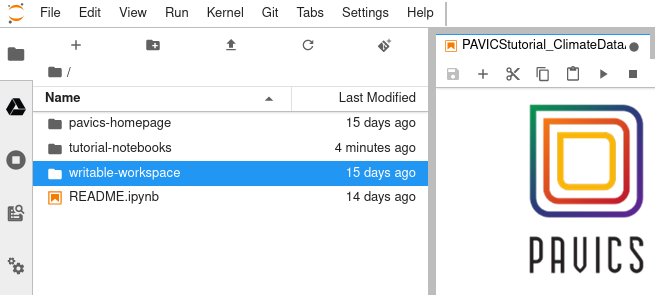

*[return to top of page](#top)*